In [17]:
import math
import numpy as np
import matplotlib.pyplot as plt
import random

In [2]:
def f(x):
    return 3*x**2 - 4*x + 5

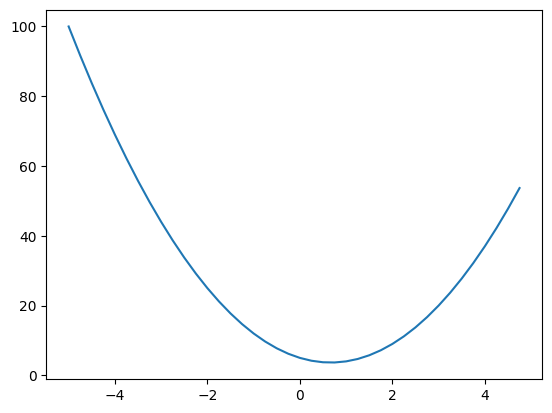

In [3]:
xs = np.arange(-5, 5, 0.25)
ys = f(xs)

plt.plot(xs, ys)
plt.show()

In [4]:
h = 0.00001
x = 2 
(f(x + h) - f(x))/h

8.000030000054892

In [5]:
a = 2.0 
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [6]:
#Evaluating simple derivatives

h = 0.0001

a = 2.0 
b = -3.0
c = 10.0
f = a*b + c

# Variable we are differentiating with respect to
c += h 

# adding a slight nudge to the variable we are differentiating our function with respect to
Df = a*b + c

print('f', f)
print('Df', Df)

print('slope', (Df - f)/h)

f 4.0
Df 4.0001
slope 0.9999999999976694


In [124]:
class Value:
    def __init__(self, data, _children=(), _op='', label=''):
        self.data = data
        self.grad = 0.0
        self._backward = lambda: None
        self._prev = set(_children)
        self._op = _op
        self.label = label
        
    def __repr__(self):
        """ Representation of the Value when we access it directly"""
        return f"Value(data={self.data})"

    def __add__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data + other.data, (self, other), '+')

        def _backward():
            self.grad += out.grad
            other.grad += out.grad
        out._backward = _backward

        return out
    def __neg__(self):
        return self * -1

    def __sub__(self, other):
        return self + (-other)
    
    def __radd__(self, other):
        return self + other

    def __rmul__(self, other): #checks if python can mulitply other * self
        return self * other

    def __mul__(self, other):
        other = other if isinstance(other, Value) else Value(other)
        out = Value(self.data * other.data, (self, other), '*')

        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __pow__(self, other):
        assert isinstance(other, (int, float)), "only supports int/float powers"
        out = Value(self.data**other, (self, ), f'**{other}')

        def _backward():
            self.grad += other * self.data ** (other-1) * out.grad
        
        out._backward = _backward
        return out

    def __truediv__(self, other):
        return self * (other ** -1)

    def backward(self):
        topo = []
        visited = set()
        def build_topo(v):
            if v not in visited:
                visited.add(v)
                for child in v._prev:
                    build_topo(child)
                topo.append(v)
        build_topo(self)

        self.grad = 1.0 

        for node in reversed(topo):
            node._backward()

    def exp(self):
        x = self.data
        out = Value(math.exp(x), (self, ), 'exp')

        def _backward():
            self.grad += out.data * out.grad

        out._backward = _backward
        return out

    def tanh(self):
        tanh = (math.exp(2*self.data) - 1)/(math.exp(2*self.data) + 1)
        out = Value(tanh, (self, ), 'tanh')

        def _backward():
            self.grad += (1 - out.data**2) * out.grad
        out._backward = _backward
        return out



In [8]:
a = Value(2.0)
a._backward()

a / a

Value(data=1.0)

In [9]:
from graphviz import Digraph
def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})
    
    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))
    
    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)
    
    return dot

To evaluate the next gradient in in the graph we have to use the chain rule: 
$$ \frac{\partial L}{\partial c} = \frac{\partial L}{\partial d} \frac{\partial d}{\partial c} 

In [10]:
x1 = Value(2.0 , label='x1')
x2 = Value(0.0, label='x2')

w1  = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')

b = Value(6.88137358, label='b')

x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'

x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'

e = (2*n).exp()
o = (e -1)/(e + 1)

o.backward()

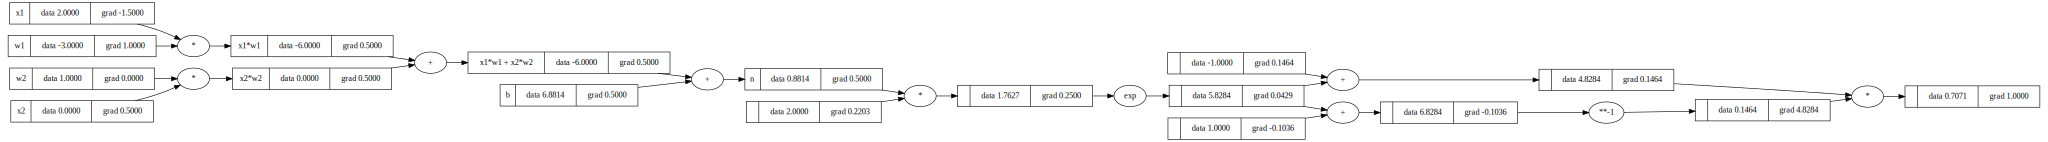

In [11]:
draw_dot(o)

In [98]:
class Neuron:
  
  def __init__(self, nin):
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]
    self.b = Value(random.uniform(-1,1))
  
  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)
    out = act.tanh()
    return out
  
  def parameters(self):
    return self.w + [self.b]


class Layer:
    def __init__(self, nin, nout):
      self.neurons = [Neuron(nin) for _ in range(nout)]
    
    def __call__(self, x):
      out = [neuron(x) for neuron in self.neurons]
      return out[0] if len(out) == 1 else out

    def parameters(self):
      return [p for neuron in self.neurons for p in neuron.parameters()]

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


In [180]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0]

mlp = MLP(3, [2, 1])

losses = []
for k in range(20):
  # forward pass
  ypred = [mlp(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  losses.append(loss.data)
  for p in mlp.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in mlp.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)
  

0 5.6705277461234385
1 4.360906980576227
2 4.069588170315953
3 3.9255634740920815
4 3.725955869064359
5 3.2785844283628056
6 2.284796698135614
7 1.1104972474919268
8 0.5312271460910223
9 0.30370684244334767
10 0.20268007644218544
11 0.14896448747030147
12 0.11644851061447264
13 0.09493233847892124
14 0.07976228353270837
15 0.068550783442772
16 0.05995939605324625
17 0.053184562994851386
18 0.04771689664091358
19 0.04321893525033967


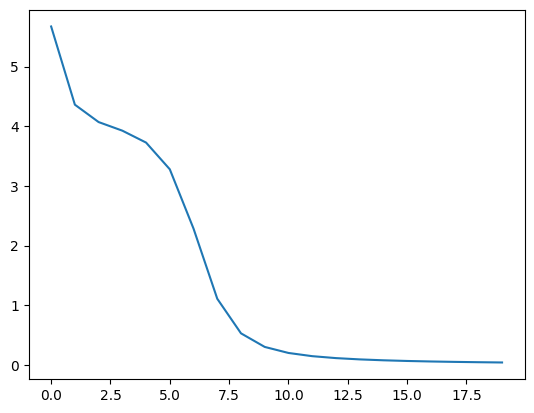

In [181]:
plt.plot(range(len(losses)), losses)
plt.show()

In [183]:
ypred

[Value(data=0.920272326902955),
 Value(data=-0.9481086371004566),
 Value(data=-0.86943910999591),
 Value(data=0.869142925867043)]